## Lab 1.3 - Predicting Real Estate Data in St. Petersburg
We have data from Yandex.Realty classified https://realty.yandex.ru containing real estate listings for apartments in St. Petersburg and Leningrad Oblast from 2016 till the middle of August 2018. In this Lab you'll learn how to apply machine learning algorithms to solve business problems. Accurate price prediction can help to find fraudsters automatically and help Yandex.Realty users to make better decisions when buying and selling real estate.

Using python with machine learning algotithms is the #1 option for prototyping solutions among data scientists today. We'll take a look at it in this lab.

### Main objectives
After successful completion of the lab work students will be able to:
-	Apply machine learning for solving price prediction problem
-   Calculate metrics which can help us find out whether our machine learning model is ready for production

### Tasks
-	Encode dataset
-	Split dataset to train and validation datasets
-	Apply decision tree algorithm to build ML (machine learning) model for price predictions
-   Calculate metrics
-   Try other algorithms and factors to get a better solution 


### 1. Load data with real estate prices

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.style as style
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.metrics import mean_absolute_percentage_error as mape

import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
style.use('fivethirtyeight')

In [38]:
rent_df_cleaned = pd.read_csv('cleaned_dataset.tsv', on_bad_lines='skip', sep='\t')

In [39]:
rent_df_cleaned.head()

,offer_id,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,renovation,offer_type,unified_address,building_id,price_per_sq_m,house_price_sqm_median
0,1100202,2015-01-24T00:00:00+03:00,2016-01-19T00:00:00+03:00,20000.0,7,0,1,0,28.0,8.0,20.0,3.0,2,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,714.285714,512.820513
1,4593125,2015-11-17T00:00:00+03:00,2016-03-04T00:00:00+03:00,24000.0,4,0,2,0,59.0,10.0,35.0,3.0,2,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,406.779661,512.820513
2,4586184,2015-11-17T00:00:00+03:00,2016-04-24T00:00:00+03:00,18000.0,6,0,1,0,36.0,9.0,17.0,3.0,2,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,500.000000,512.820513
3,5308071,2016-02-04T00:00:00+03:00,2016-02-28T00:00:00+03:00,18000.0,8,0,1,0,39.0,10.0,18.0,0.0,2,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,461.538462,512.820513
4,7534283612538021121,2016-02-28T00:00:00+03:00,2016-04-02T00:00:00+03:00,19000.0,3,0,1,0,36.0,8.0,18.0,11.0,2,"Россия, Санкт-Петербург, Богатырский проспект, 5к1",6719200042030752141,527.777778,512.820513


In [40]:
rent_df_cleaned = rent_df_cleaned[['first_day_exposition', 'last_day_exposition', 'area', 'last_price', 'open_plan', 'rooms', 'renovation']]
rent_df_cleaned

,first_day_exposition,last_day_exposition,area,last_price,open_plan,rooms,renovation
0,2015-01-24T00:00:00+03:00,2016-01-19T00:00:00+03:00,28.0,20000.0,0,1,3.0
1,2015-11-17T00:00:00+03:00,2016-03-04T00:00:00+03:00,59.0,24000.0,0,2,3.0
2,2015-11-17T00:00:00+03:00,2016-04-24T00:00:00+03:00,36.0,18000.0,0,1,3.0
3,2016-02-04T00:00:00+03:00,2016-02-28T00:00:00+03:00,39.0,18000.0,0,1,0.0
4,2016-02-28T00:00:00+03:00,2016-04-02T00:00:00+03:00,36.0,19000.0,0,1,11.0
...,...,...,...,...,...,...,...
155495,2018-08-20T00:00:00+03:00,2018-08-20T00:00:00+03:00,32.0,26000.0,0,1,NaN
155496,2018-08-20T00:00:00+03:00,2018-08-20T00:00:00+03:00,39.0,27000.0,0,1,NaN
155497,2018-08-20T00:00:00+03:00,2018-08-20T00:00:00+03:00,67.0,30000.0,0,2,NaN
155498,2018-08-20T00:00:00+03:00,2018-08-20T00:00:00+03:00,56.0,50000.0,0,2,NaN


In [41]:
rent_df_cleaned['log_last_price'] = np.log(rent_df_cleaned['last_price'])

In [42]:
rent_df_cleaned.tail(3)

,first_day_exposition,last_day_exposition,area,last_price,open_plan,rooms,renovation,log_last_price
155497,2018-08-20T00:00:00+03:00,2018-08-20T00:00:00+03:00,67.0,30000.0,0,2,NaN,10.308953
155498,2018-08-20T00:00:00+03:00,2018-08-20T00:00:00+03:00,56.0,50000.0,0,2,NaN,10.819778
155499,2017-09-12T00:00:00+03:00,2018-08-20T00:00:00+03:00,46.0,55000.0,0,2,11.0,10.915088


In [43]:
rent_df_cleaned.describe()

,area,last_price,open_plan,rooms,renovation,log_last_price
count,155500.000000,155500.000000,155500.000000,155500.000000,102751.000000,155500.000000
mean,53.388608,31879.141505,0.000051,1.600071,3.696937,10.243185
std,24.134163,20301.276025,0.007172,0.873182,4.489422,0.461293
min,11.000000,130.000000,0.000000,0.000000,0.000000,4.867534
25%,38.000000,20000.000000,0.000000,1.000000,0.000000,9.903488
50%,46.000000,25000.000000,0.000000,1.000000,1.000000,10.126631
75%,62.000000,35000.000000,0.000000,2.000000,10.000000,10.463103
max,200.000000,199000.000000,1.000000,5.000000,11.000000,12.201060


### 2. Data Transformation

In [44]:
(rent_df_cleaned.isna().sum() / len(rent_df_cleaned)).rename('percent of NA').to_frame().style.bar(vmax=1, vmin=0).format('{:.2%}')

,percent of NA
first_day_exposition,0.00%
last_day_exposition,0.00%
area,0.00%
last_price,0.00%
open_plan,0.00%
rooms,0.00%
renovation,33.92%
log_last_price,0.00%


In [45]:
rent_df_cleaned.renovation.value_counts()

0.0     50225
3.0     16422
11.0    14088
10.0    13885
7.0      3885
1.0      3126
6.0       699
8.0       226
2.0       162
4.0        32
5.0         1
Name: renovation, dtype: int64

In [46]:
rent_df_cleaned.first_day_exposition = pd.to_datetime(rent_df_cleaned.first_day_exposition)
rent_df_cleaned.last_day_exposition = pd.to_datetime(rent_df_cleaned.last_day_exposition)

In [47]:
rent_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155500 entries, 0 to 155499
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype                                
---  ------                --------------   -----                                
 0   first_day_exposition  155500 non-null  datetime64[ns, pytz.FixedOffset(180)]
 1   last_day_exposition   155500 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   area                  155500 non-null  float64                              
 3   last_price            155500 non-null  float64                              
 4   open_plan             155500 non-null  int64                                
 5   rooms                 155500 non-null  int64                                
 6   renovation            102751 non-null  float64                              
 7   log_last_price        155500 non-null  float64                              
dtypes: datetime64[ns, pytz.FixedOffset(180)](2), float64(4), int64(2)

In [48]:
rent_df_cleaned['days_published'] = (rent_df_cleaned['last_day_exposition'] - rent_df_cleaned['first_day_exposition']).dt.days

In [49]:
rent_df_cleaned.head()

,first_day_exposition,last_day_exposition,area,last_price,open_plan,rooms,renovation,log_last_price,days_published
0,2015-01-24 00:00:00+03:00,2016-01-19 00:00:00+03:00,28.0,20000.0,0,1,3.0,9.903488,360
1,2015-11-17 00:00:00+03:00,2016-03-04 00:00:00+03:00,59.0,24000.0,0,2,3.0,10.085809,108
2,2015-11-17 00:00:00+03:00,2016-04-24 00:00:00+03:00,36.0,18000.0,0,1,3.0,9.798127,159
3,2016-02-04 00:00:00+03:00,2016-02-28 00:00:00+03:00,39.0,18000.0,0,1,0.0,9.798127,24
4,2016-02-28 00:00:00+03:00,2016-04-02 00:00:00+03:00,36.0,19000.0,0,1,11.0,9.852194,34


In [50]:
renovation_encoded = pd.get_dummies(rent_df_cleaned, columns=['renovation','open_plan','rooms'])

In [51]:
renovation_encoded.head(3)

,first_day_exposition,last_day_exposition,area,last_price,log_last_price,days_published,renovation_0.0,renovation_1.0,renovation_2.0,renovation_3.0,renovation_4.0,renovation_5.0,renovation_6.0,renovation_7.0,renovation_8.0,renovation_10.0,renovation_11.0,open_plan_0,open_plan_1,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,rooms_5
0,2015-01-24 00:00:00+03:00,2016-01-19 00:00:00+03:00,28.0,20000.0,9.903488,360,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,2015-11-17 00:00:00+03:00,2016-03-04 00:00:00+03:00,59.0,24000.0,10.085809,108,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,2015-11-17 00:00:00+03:00,2016-04-24 00:00:00+03:00,36.0,18000.0,9.798127,159,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [52]:
std_scaler = StandardScaler().fit(renovation_encoded[['area','days_published']])
data_std_scaled = std_scaler.transform(renovation_encoded[['area','days_published']])

minmax_scaler = MinMaxScaler().fit(renovation_encoded[['area','days_published']])
data_minmax_scaled = minmax_scaler.transform(renovation_encoded[['area','days_published']])

In [53]:
renovation_encoded['st-ed_area'] = data_std_scaled[:,0]
renovation_encoded['st-ed_days_published'] = data_std_scaled[:,1]

In [54]:
renovation_encoded.head()

,first_day_exposition,last_day_exposition,area,last_price,log_last_price,days_published,renovation_0.0,renovation_1.0,renovation_2.0,renovation_3.0,renovation_4.0,renovation_5.0,renovation_6.0,renovation_7.0,renovation_8.0,renovation_10.0,renovation_11.0,open_plan_0,open_plan_1,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,rooms_5,st-ed_area,st-ed_days_published
0,2015-01-24 00:00:00+03:00,2016-01-19 00:00:00+03:00,28.0,20000.0,9.903488,360,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,-1.051981,1.104954
1,2015-11-17 00:00:00+03:00,2016-03-04 00:00:00+03:00,59.0,24000.0,10.085809,108,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0.232509,-0.032804
2,2015-11-17 00:00:00+03:00,2016-04-24 00:00:00+03:00,36.0,18000.0,9.798127,159,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,-0.720500,0.197456
3,2016-02-04 00:00:00+03:00,2016-02-28 00:00:00+03:00,39.0,18000.0,9.798127,24,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,-0.596194,-0.412056
4,2016-02-28 00:00:00+03:00,2016-04-02 00:00:00+03:00,36.0,19000.0,9.852194,34,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,-0.720500,-0.366907


In [56]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

y = renovation_encoded['last_price']
data = renovation_encoded
X = renovation_encoded.drop(columns=['last_day_exposition', 'first_day_exposition', 'first_day_exposition','log_last_price','last_price'])

In [57]:
X

,area,days_published,renovation_0.0,renovation_1.0,renovation_2.0,renovation_3.0,renovation_4.0,renovation_5.0,renovation_6.0,renovation_7.0,renovation_8.0,renovation_10.0,renovation_11.0,open_plan_0,open_plan_1,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,rooms_5,st-ed_area,st-ed_days_published
0,28.0,360,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,-1.051981,1.104954
1,59.0,108,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0.232509,-0.032804
2,36.0,159,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,-0.720500,0.197456
3,39.0,24,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,-0.596194,-0.412056
4,36.0,34,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,-0.720500,-0.366907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155495,32.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,-0.886241,-0.520414
155496,39.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,-0.596194,-0.520414
155497,67.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0.563990,-0.520414
155498,56.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0.108203,-0.520414


### Models

In [91]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()

X_train = sc_X.fit_transform(X_train)
X_valid = sc_X.fit_transform(X_valid)
y_train = sc_y.fit_transform(y_train)
y_valid = sc_y.fit_transform(y_valid)

NameError: name 'X_valid' is not defined

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

#### Tree

In [78]:
dt = DecisionTreeRegressor(max_depth=8, min_samples_leaf=19, max_features=22)
dt.fit(X_train, y_train)

dt_pred_train = dt.predict(X_train)
dt_pred_test = dt.predict(X_test)


mape_test  = mape(y_test ,dt_pred_test)
mape_train = mape(y_train ,dt_pred_train)

print('-------------ДЕРЕВО-------------')
accuracy = dt.score(X_test,y_test)
print("MAPE_test = {:.2f}".format((mape_test)))
print('Accuracy = ', accuracy*100,'%')
print("MAPE_train = {:.2f}".format((mape_train)))
print('Accuracy = ', accuracy*100,'%')

-------------ДЕРЕВО-------------
MAPE_test = 0.23
Accuracy =  63.0047664166125 %
MAPE_train = 0.22
Accuracy =  63.0047664166125 %


In [ ]:
#TUNING

from sklearn.model_selection import GridSearchCV
first_tree = DecisionTreeRegressor(random_state=7)
tree_params = {'max_depth': np.arange(1, 20, 1),
              'min_samples_leaf': np.arange(1, 20, 1),
              'max_features': np.arange(1, 23, 1)}

tree_grid = GridSearchCV(first_tree, tree_params, cv = 5, n_jobs=-1)
%time
tree_grid.fit(X_train, y_train);

In [ ]:
tree_grid.best_params_

In [82]:
from sklearn.tree import plot_tree

Tree depth: 8


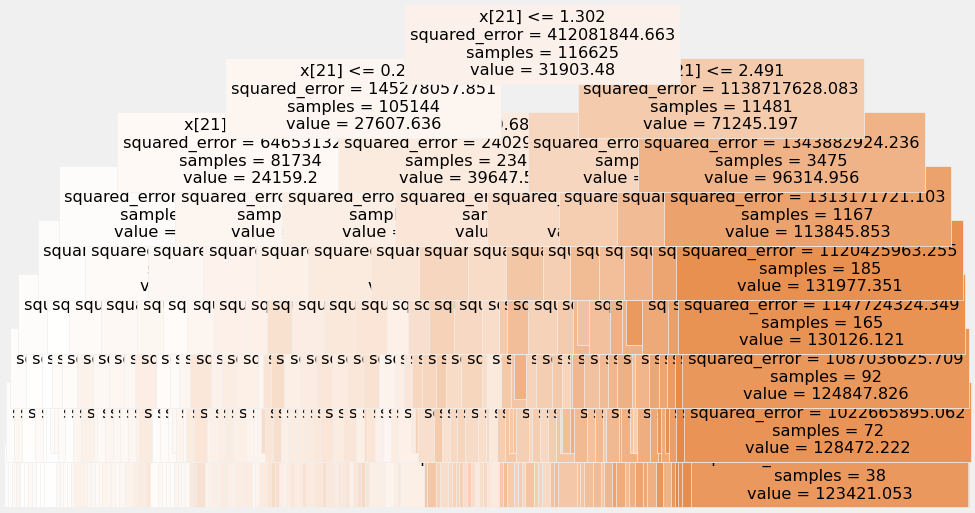

In [83]:
print (f'Tree depth: {dt.get_depth()}')
fig = plt.figure(figsize=(8, 6))

plot_tree(dt, filled=True, ax=fig.gca(), fontsize='small');

In [84]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0, max_features = 'auto', max_depth = 20, 
                                 min_samples_split = 4, min_samples_leaf =8, n_jobs =-1)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_pred_train = regressor.predict(X_train)

In [85]:
print('-------------ЛЕС-------------')
print("MAPE_test = {:.5f}".format((mape(y_test, y_pred)*100)))
print("MAPE_train = {:.5f}".format((mape(y_train, y_pred_train)*100)))
accuracy = regressor.score(X_test,y_test)
print('Accuracy = ', accuracy*100,'%')

-------------ЛЕС-------------
MAPE_test = 22.62278
MAPE_train = 19.53073
Accuracy =  63.528915288287834 %


#### RandomizedSearchCV

In [ ]:
param_dist = {
    'max_depth': [10, 15, 20, 25, 30, 40, 50, 60, 70],
    'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35, 40],
    'max_features': [2, 3, 4],
    'min_samples_split': [2, 3, 4, 5, 6, 7],
    'splitter': ['best', 'random'],
    'criterion': ['mse', 'mae'],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
}


dt = DecisionTreeRegressor()
random_search = RandomizedSearchCV(dt, param_dist, n_iter=50, scoring='neg_mean_squared_error', cv=5)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

predictions = best_model.predict(X_valid)
mae = mean_absolute_error(y_valid, predictions)
mse = mean_squared_error(y_valid, predictions)
rmse = np.sqrt(mse)

print('Best parameters:', random_search.best_params_)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)

In [87]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 150, num = 10)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
print(random_grid)

{'n_estimators': [20, 34, 48, 63, 77, 92, 106, 121, 135, 150], 'max_features': ['auto'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [2, 4]}


In [88]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=63; total time=  11.8s
[CV] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=77; total time=  16.4s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=77; total time=  15.2s
[CV] END max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=121; total time=  24.0s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=  29.7s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=48; total time=  10.2s
[CV] END max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=135; total time=  26.6s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=92; total time=  19.6s
[CV] END max_depth=20, max_features=auto,

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=63; total time=  11.9s
[CV] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=77; total time=  16.4s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=77; total time=  15.1s
[CV] END max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=121; total time=  23.9s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=150; total time=  29.7s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=48; total time=  10.2s
[CV] END max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=135; total time=  26.6s
[CV] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=92; total time=  19.7s
[CV] END max_depth=20, max_features=auto,

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [2, 4],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [20, 34, 48, 63, 77, 92,
                                                         106, 121, 135, 150]},
                   random_state=42, verbose=2)

#### XGBoost

In [89]:
import xgboost as xgb

XG = xgb.XGBRegressor()

XG.fit(X_train, y_train)
y_pred = XG.predict(X_test)
y_pred_train = XG.predict(X_train)
print('-------------БУСТ-------------')

print("MAPE_test = {:.5f}".format((mape(y_test, y_pred)*100)))
print("MAPE_train = {:.5f}".format((mape(y_train, y_pred_train)*100)))
accuracy = regressor.score(X_test,y_test)
print('Accuracy = ', accuracy*100,'%')

-------------БУСТ-------------
MAPE_test = 22.30787
MAPE_train = 20.51463
Accuracy =  63.528915288287834 %


In [90]:
import joblib

model_file = 'model.pkl'
scaler_x = 'scaler_x-pkl'
scaler_y = 'scaler_y-pkl'
joblib.dump (sc_X, scaler_x)
joblib.dump (sc_y, scaler_y)
joblib.dump(random_forest_model, model_file)

['model.pkl']

In [ ]:
param_dist = {
    'max_depth': [10, 15, 20, 25, 30, 40, 50, 60, 70],
    'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35, 40],
    'max_features': [2, 3, 4],
    'min_samples_split': [2, 3, 4, 5, 6, 7],
    'splitter': ['best', 'random'],
    'criterion': ['mse', 'mae'],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
}


dt = DecisionTreeRegressor()
random_search = RandomizedSearchCV(dt, param_dist, n_iter=50, scoring='neg_mean_squared_error', cv=5)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

predictions = best_model.predict(X_valid)
mae = mean_absolute_error(y_valid, predictions)
mse = mean_squared_error(y_valid, predictions)
rmse = np.sqrt(mse)

print('Best parameters:', random_search.best_params_)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)